In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit_aer import AerSimulator

from HDT_circuit_qiskit import HEA_circuit_sampler

import time

sns.set()

In [2]:
def get_cond_prob(bit_string_counts, n_data):
    # convert count dict to pd frame
    df = pd.DataFrame.from_dict(
        bit_string_counts, orient='index').reset_index()
    df.columns = ['bits', 'counts']

    # split data and ancilla
    df['data_bits'] = df['bits'].str[-n_data:]
    df['bath_bits'] = df['bits'].str[:-n_data]
    df = df.drop('bits', axis=1)

    # find result with 00 data bit
    A0_bits = df[df['data_bits'] == '0'*n_data]
    A0_bits = A0_bits.rename(
        columns={'counts': 'cond_counts'}).drop('data_bits', axis=1)

    # compute cond prob using left merge
    ZB_df = df.groupby('bath_bits').sum(numeric_only=True).reset_index()
    ZB_df = ZB_df.merge(A0_bits, on='bath_bits', how='left').fillna(0)
    ZB_df['cond_prob'] = ZB_df['cond_counts'] / ZB_df['counts']
    ZB_df = ZB_df.drop(['cond_counts', 'bath_bits'], axis=1)

    # expand into long format
    #ZB_df = ZB_df.reindex(ZB_df.index.repeat(ZB_df['counts']))
    
    return ZB_df['cond_prob'].to_numpy()

In [3]:
def pt_density(x, n):
    return (2 ** n - 1) * (1 - x) ** (2 ** n - 2)

def pt_cdf(x, n):
    return 1. - (1.-x)**(2**n-1.)

## 2 Qubits, HEA circuit

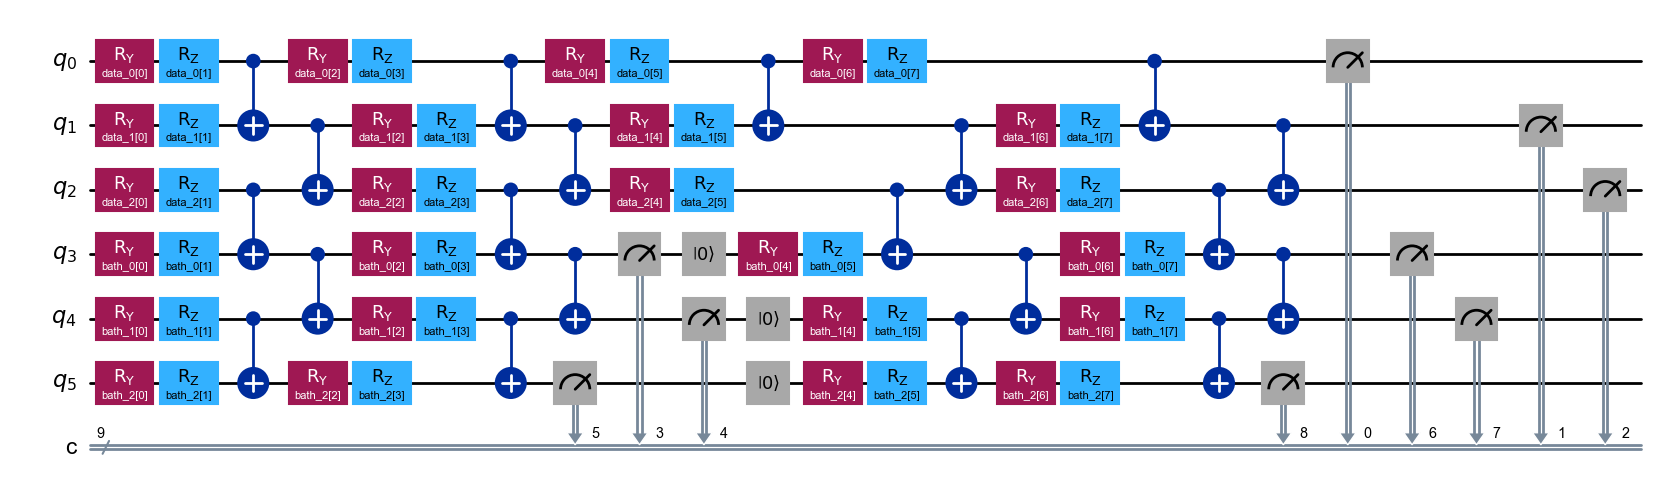

In [4]:
circuit = HEA_circuit_sampler(2, 2, 3, 3)
circuit.draw('mpl')

# PoP dynamics simulation, $n_A, n_B=2,2$

In [5]:
n_data = 2
n_bath = 2
n_depth = (n_data + n_bath)
n_shot = 1e6

res_all = []
for n_step in  [1, 3, 5, 6]:
    t0 = time.time()
    np.random.seed(1)
    circuit = HEA_circuit_sampler(n_step, n_depth, n_data, n_bath)

    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    bound_circuit = circuit.assign_parameters(param_random)

    # simulate
    job = AerSimulator().run(bound_circuit, shots=n_shot)
    res = job.result().get_counts(bound_circuit)
    res_all.append(res)
    print(f'step={n_step}, time={time.time() - t0:.3f}')

step=1, time=3.600
step=3, time=4.969
step=5, time=7.641
step=6, time=9.005


Text(0.5, 1.0, 'Noiseless, Na=2, Nb=2, L=8, shots=1e6')

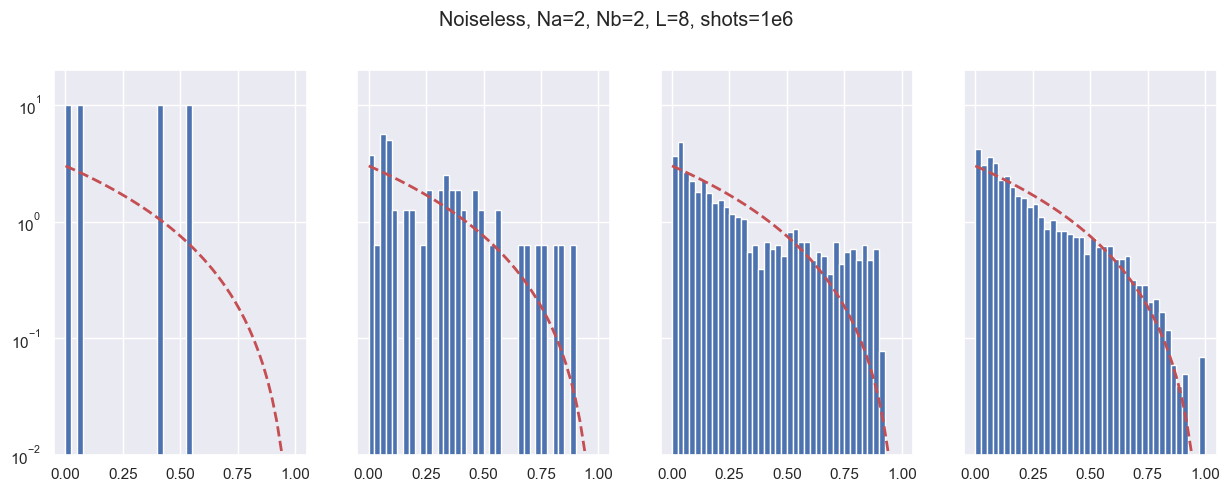

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(4):
    axs[i].hist(get_cond_prob(res_all[i], n_data), bins=np.linspace(0, 1, 41), density=True)
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
axs[0].set_yscale('log')
axs[0].set_ylim(0.01, 20)

fig.suptitle(f'Noiseless, Na=2, Nb=2, L=8, shots=1e6', y=1.)

# PoP dynamics simulation, $n_A, n_B=4,4$

In [7]:
n_data = 4
n_bath = 4
n_depth = (n_data + n_bath)
n_shot = 1e6

res_all = []
for n_step in [1, 2, 4]:
    t0 = time.time()
    np.random.seed(1)
    circuit = HEA_circuit_sampler(n_step, n_depth, n_data, n_bath)

    n_total_param = (n_data + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
    bound_circuit = circuit.assign_parameters(param_random)

    # simulate
    job = AerSimulator().run(bound_circuit, shots=n_shot)
    res = job.result().get_counts(bound_circuit)
    res_all.append(res)
    print(f'step={n_step}, time={time.time() - t0:.3f}')

step=1, time=3.735
step=2, time=15.420
step=4, time=31.574


Text(0.5, 1.0, 'Noiseless, Na=4, Nb=4, L=8, shots=1e5')

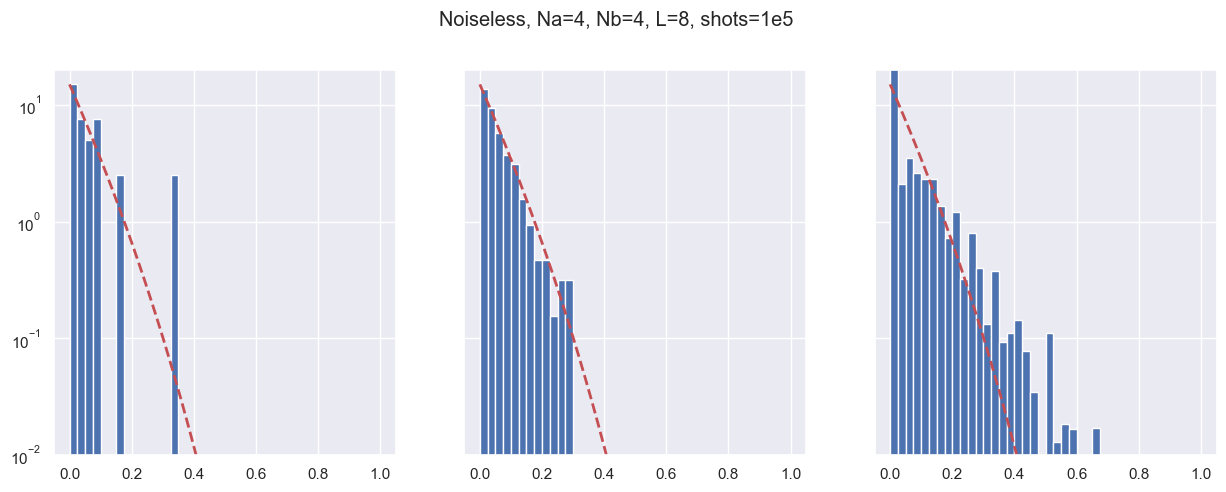

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
qs = np.linspace(0, 100, 51)/100
for i in range(3):
    axs[i].hist(get_cond_prob(res_all[i], n_data), bins=np.linspace(0, 1, 41), density=True)
    axs[i].plot(qs, pt_density(qs, n_data), '--', lw=2, color='r')
axs[0].set_yscale('log')
axs[0].set_ylim(0.01, 20)

fig.suptitle(f'Noiseless, Na=4, Nb=4, L=8, shots=1e5', y=1.)